# Deliverable 3: Data Preprocessing Pipeline + Baseline ML Models

## AI-Powered Resume Screening System - Machine Learning

**Goal:** Build a complete data preprocessing pipeline and train baseline ML models to classify resumes into job categories.

---

## Table of Contents
1. Load Dataset
2. Data Exploration & Cleaning
3. Feature Engineering (TF-IDF + Structured Features)
4. Train-Test Split
5. Baseline Model 1: Random Forest
6. Baseline Model 2: Logistic Regression
7. Model Comparison & Evaluation
8. Visualizations

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Step 1: Load Dataset

In [4]:
# Download dataset using kagglehub
import kagglehub

path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")
print(f"Dataset path: {path}")

# Load the data
df = pd.read_csv(path + '/Resume/Resume.csv')

print(f"\n📊 Dataset Information:")
print(f"Total resumes: {len(df)}")
print(f"Number of job categories: {df['Category'].nunique()}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nDataset shape: {df.shape}")

Dataset path: /Users/macbookpro/.cache/kagglehub/datasets/snehaanbhawal/resume-dataset/versions/1

📊 Dataset Information:
Total resumes: 2484
Number of job categories: 24
Columns: ['ID', 'Resume_str', 'Resume_html', 'Category']

Dataset shape: (2484, 4)

📊 Dataset Information:
Total resumes: 2484
Number of job categories: 24
Columns: ['ID', 'Resume_str', 'Resume_html', 'Category']

Dataset shape: (2484, 4)


## Step 2: Data Exploration & Cleaning

Missing values:
ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

📋 Job Category Distribution:
Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


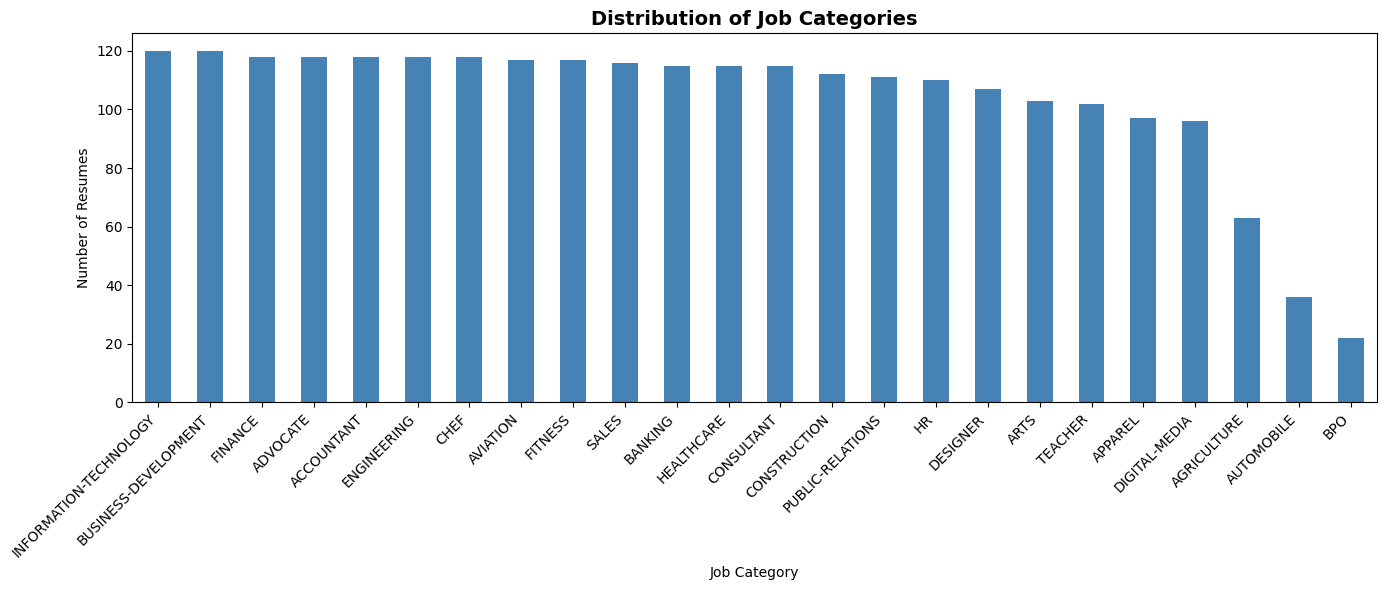

In [5]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Display category distribution
print("\n📋 Job Category Distribution:")
print(df['Category'].value_counts())

# Visualize category distribution
plt.figure(figsize=(14, 6))
df['Category'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Distribution of Job Categories', fontsize=14, fontweight='bold')
plt.xlabel('Job Category')
plt.ylabel('Number of Resumes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [6]:
# Text cleaning function
def clean_resume_text(text):
    """
    Clean resume text by:
    1. Removing URLs
    2. Removing special characters
    3. Converting to lowercase
    4. Removing extra whitespace
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove special characters but keep letters, numbers, and spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply cleaning
print("🧹 Cleaning resume text...")
df['Resume_cleaned'] = df['Resume_str'].apply(clean_resume_text)

# Display example
print("\n📄 Original Resume (first 200 chars):")
print(df['Resume_str'].iloc[0][:200])
print("\n📄 Cleaned Resume (first 200 chars):")
print(df['Resume_cleaned'].iloc[0][:200])

print("\n✅ Text cleaning complete!")

🧹 Cleaning resume text...

📄 Original Resume (first 200 chars):
         HR ADMINISTRATOR/MARKETING ASSOCIATE

HR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Resp

📄 Cleaned Resume (first 200 chars):
hr administrator marketing associate hr administrator summary dedicated customer service manager with 15 years of experience in hospitality and customer service management respected builder and leader

✅ Text cleaning complete!

📄 Original Resume (first 200 chars):
         HR ADMINISTRATOR/MARKETING ASSOCIATE

HR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Resp

📄 Cleaned Resume (first 200 chars):
hr administrator marketing associate hr administrator summary dedicated customer service manager with 15 years of experience in hospitality and customer service management respected builder and 

## Step 3: Feature Engineering

We'll create two types of features:
1. **TF-IDF Features**: Capture important words in resumes
2. **Structured Features**: Skills count, resume length, word count

In [7]:
# 1. TF-IDF Features (Text Vectorization)
print("🔤 Creating TF-IDF features...")

# TF-IDF converts text into numerical features
# max_features=300 means we keep the 300 most important words
# ngram_range=(1,2) means we consider both single words and pairs of words
vectorizer = TfidfVectorizer(
    max_features=300, 
    stop_words='english',  # Remove common words like 'the', 'is', etc.
    ngram_range=(1, 2)     # Use unigrams and bigrams
)

# Fit and transform the cleaned resume text
tfidf_features = vectorizer.fit_transform(df['Resume_cleaned'])

print(f"✅ TF-IDF features created: {tfidf_features.shape}")
print(f"   Number of resumes: {tfidf_features.shape[0]}")
print(f"   Number of TF-IDF features: {tfidf_features.shape[1]}")

🔤 Creating TF-IDF features...
✅ TF-IDF features created: (2484, 300)
   Number of resumes: 2484
   Number of TF-IDF features: 300
✅ TF-IDF features created: (2484, 300)
   Number of resumes: 2484
   Number of TF-IDF features: 300


In [8]:
# 2. Structured Features
print("\n🔧 Creating structured features...")

# Count skills in each resume
def count_skills(text):
    """Count how many technical skills appear in the resume"""
    skills = ['python', 'java', 'sql', 'javascript', 'machine learning', 
              'aws', 'docker', 'react', 'nodejs', 'git', 'excel', 
              'data analysis', 'leadership', 'management']
    count = sum(1 for skill in skills if skill in text.lower())
    return count

# Create structured features
df['num_skills'] = df['Resume_str'].apply(count_skills)
df['resume_length'] = df['Resume_cleaned'].apply(len)
df['word_count'] = df['Resume_cleaned'].apply(lambda x: len(x.split()))

print("✅ Structured features created:")
print(f"   - num_skills: Count of technical skills")
print(f"   - resume_length: Character count")
print(f"   - word_count: Number of words")

# Display examples
print("\n📊 Feature Examples:")
print(df[['num_skills', 'resume_length', 'word_count']].head())


🔧 Creating structured features...
✅ Structured features created:
   - num_skills: Count of technical skills
   - resume_length: Character count
   - word_count: Number of words

📊 Feature Examples:
   num_skills  resume_length  word_count
0           4           4859         658
1           2           5042         707
2           3           7168        1042
3           2           2597         375
4           4           8619        1219
✅ Structured features created:
   - num_skills: Count of technical skills
   - resume_length: Character count
   - word_count: Number of words

📊 Feature Examples:
   num_skills  resume_length  word_count
0           4           4859         658
1           2           5042         707
2           3           7168        1042
3           2           2597         375
4           4           8619        1219


In [9]:
# 3. Combine all features
from scipy.sparse import hstack

print("\n🔗 Combining features...")

# Get structured features as numpy array
structured_features = df[['num_skills', 'resume_length', 'word_count']].values

# Combine TF-IDF features (sparse matrix) with structured features (dense array)
X = hstack([tfidf_features, structured_features])

print(f"✅ Final feature matrix shape: {X.shape}")
print(f"   Total features: {X.shape[1]} (300 TF-IDF + 3 structured)")

# Prepare labels (job categories)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Category'])

print(f"\n📋 Labels prepared:")
print(f"   Number of classes: {len(label_encoder.classes_)}")
print(f"   Classes: {label_encoder.classes_[:5]}... (showing first 5)")


🔗 Combining features...
✅ Final feature matrix shape: (2484, 303)
   Total features: 303 (300 TF-IDF + 3 structured)

📋 Labels prepared:
   Number of classes: 24
   Classes: ['ACCOUNTANT' 'ADVOCATE' 'AGRICULTURE' 'APPAREL' 'ARTS']... (showing first 5)


## Step 4: Train-Test Split

Split data into training (80%) and testing (20%) sets:

In [10]:
# Split data: 80% training, 20% testing
# stratify=y ensures each class is proportionally represented in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% for testing
    random_state=42,    # For reproducibility
    stratify=y          # Maintain class distribution
)

print("📊 Data Split:")
print(f"Training samples: {X_train.shape[0]} ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Testing samples:  {X_test.shape[0]} ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"Features per sample: {X_train.shape[1]}")
print("\n✅ Ready to train models!")

📊 Data Split:
Training samples: 1987 (80.0%)
Testing samples:  497 (20.0%)
Features per sample: 303

✅ Ready to train models!


## Step 5: Baseline Model 1 - Random Forest Classifier

Random Forest is an ensemble learning method that combines multiple decision trees.

In [11]:
import time

print("🌲 Training Random Forest Classifier...")
start_time = time.time()

# Create Random Forest model
# n_estimators=100 means we use 100 decision trees
# max_depth=20 limits tree depth to prevent overfitting
# random_state=42 ensures reproducibility
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1  # Use all CPU cores for faster training
)

# Train the model
rf_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✅ Training completed in {training_time:.2f} seconds")

# Make predictions on test set
rf_predictions = rf_model.predict(X_test)

# Calculate performance metrics
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions, average='weighted', zero_division=0)
rf_recall = recall_score(y_test, rf_predictions, average='weighted')
rf_f1 = f1_score(y_test, rf_predictions, average='weighted')

print("\n📊 Random Forest Performance:")
print("="*50)
print(f"Accuracy:  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1-Score:  {rf_f1:.4f}")
print("="*50)

🌲 Training Random Forest Classifier...
✅ Training completed in 0.34 seconds

📊 Random Forest Performance:
Accuracy:  0.5714 (57.14%)
Precision: 0.5502
Recall:    0.5714
F1-Score:  0.5351
✅ Training completed in 0.34 seconds

📊 Random Forest Performance:
Accuracy:  0.5714 (57.14%)
Precision: 0.5502
Recall:    0.5714
F1-Score:  0.5351


## Step 6: Baseline Model 2 - Logistic Regression

Logistic Regression is a linear model for classification.

In [12]:
print("📈 Training Logistic Regression Classifier...")
start_time = time.time()

# Create Logistic Regression model
# max_iter=1000 allows enough iterations for convergence
# multi_class='auto' handles multiple job categories
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Train the model
lr_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✅ Training completed in {training_time:.2f} seconds")

# Make predictions on test set
lr_predictions = lr_model.predict(X_test)

# Calculate performance metrics
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions, average='weighted', zero_division=0)
lr_recall = recall_score(y_test, lr_predictions, average='weighted')
lr_f1 = f1_score(y_test, lr_predictions, average='weighted')

print("\n📊 Logistic Regression Performance:")
print("="*50)
print(f"Accuracy:  {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")
print("="*50)

📈 Training Logistic Regression Classifier...
✅ Training completed in 4.26 seconds

📊 Logistic Regression Performance:
Accuracy:  0.3038 (30.38%)
Precision: 0.3685
Recall:    0.3038
F1-Score:  0.2931
✅ Training completed in 4.26 seconds

📊 Logistic Regression Performance:
Accuracy:  0.3038 (30.38%)
Precision: 0.3685
Recall:    0.3038
F1-Score:  0.2931


/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Step 7: Model Comparison & Evaluation

Let's compare both models side by side:


📊 MODEL COMPARISON TABLE
              Model  Accuracy  Precision   Recall  F1-Score
      Random Forest  0.571429   0.550208 0.571429  0.535101
Logistic Regression  0.303823   0.368486 0.303823  0.293125

🏆 Best Model: Random Forest
   F1-Score: 0.5351


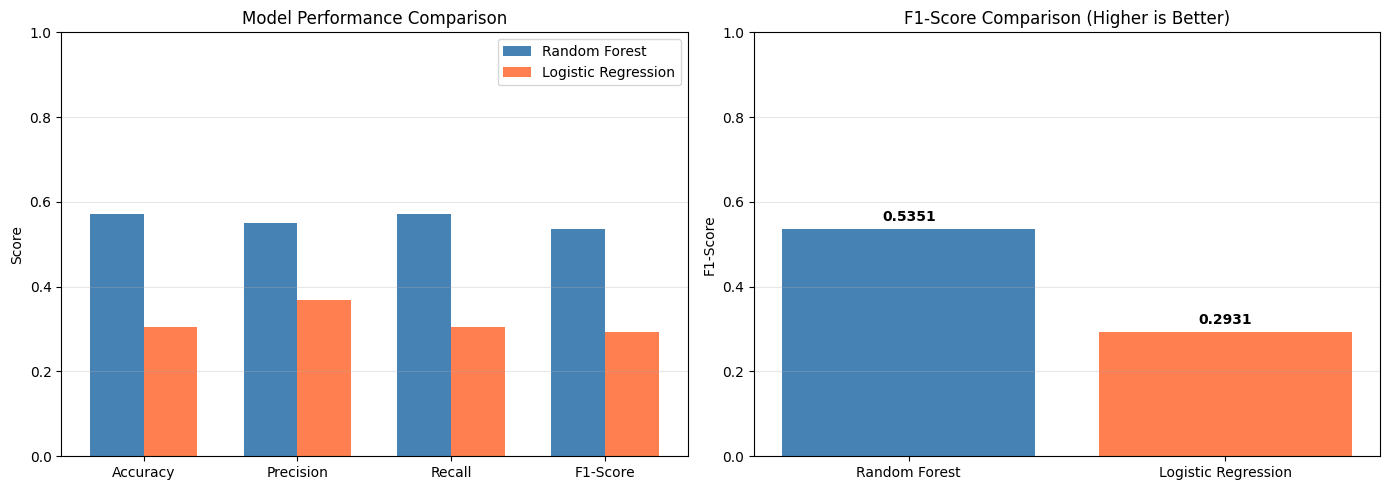

In [13]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression'],
    'Accuracy': [rf_accuracy, lr_accuracy],
    'Precision': [rf_precision, lr_precision],
    'Recall': [rf_recall, lr_recall],
    'F1-Score': [rf_f1, lr_f1]
})

print("\n📊 MODEL COMPARISON TABLE")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Determine best model
best_model_name = 'Random Forest' if rf_f1 > lr_f1 else 'Logistic Regression'
best_f1 = max(rf_f1, lr_f1)

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")

# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: All metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
rf_scores = [rf_accuracy, rf_precision, rf_recall, rf_f1]
lr_scores = [lr_accuracy, lr_precision, lr_recall, lr_f1]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, rf_scores, width, label='Random Forest', color='steelblue')
axes[0].bar(x + width/2, lr_scores, width, label='Logistic Regression', color='coral')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: F1-Score comparison
models = ['Random Forest', 'Logistic Regression']
f1_scores = [rf_f1, lr_f1]
colors = ['steelblue', 'coral']

axes[1].bar(models, f1_scores, color=colors)
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score Comparison (Higher is Better)')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Step 8: Detailed Classification Report & Confusion Matrix

In [14]:
# Classification Report for Random Forest (Best Model)
print("📋 DETAILED CLASSIFICATION REPORT - RANDOM FOREST")
print("="*70)
print(classification_report(y_test, rf_predictions, target_names=label_encoder.classes_))
print("="*70)

📋 DETAILED CLASSIFICATION REPORT - RANDOM FOREST
                        precision    recall  f1-score   support

            ACCOUNTANT       0.59      0.79      0.68        24
              ADVOCATE       0.35      0.29      0.32        24
           AGRICULTURE       1.00      0.08      0.14        13
               APPAREL       0.17      0.05      0.08        19
                  ARTS       0.56      0.24      0.33        21
            AUTOMOBILE       0.00      0.00      0.00         7
              AVIATION       0.58      0.46      0.51        24
               BANKING       0.74      0.61      0.67        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.45      0.71      0.55        24
                  CHEF       0.75      0.75      0.75        24
          CONSTRUCTION       0.79      0.86      0.83        22
            CONSULTANT       0.14      0.04      0.07        23
              DESIGNER       0.65      0.62      0.63 

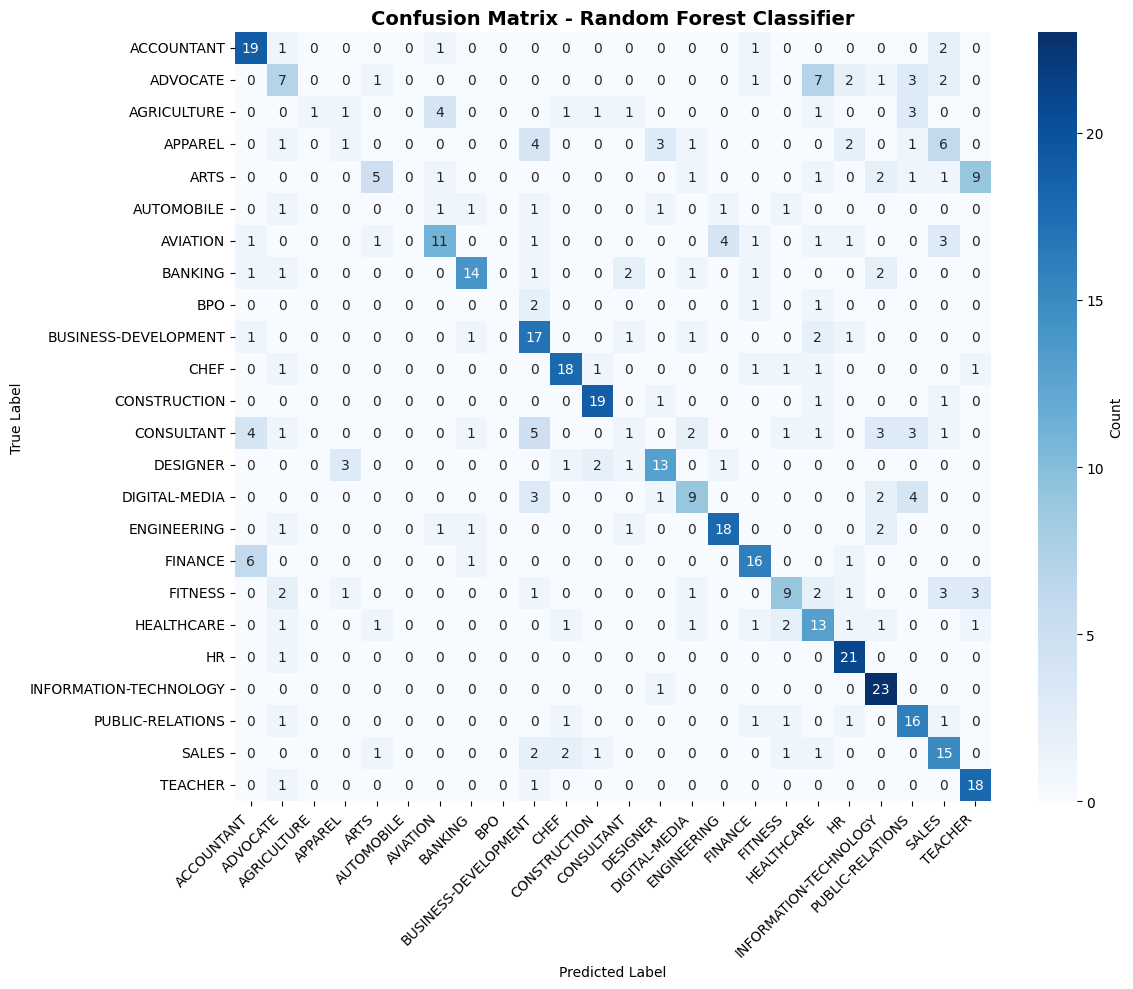


💡 Confusion Matrix Interpretation:
   - Diagonal values (dark blue) = Correct predictions
   - Off-diagonal values = Misclassifications


In [15]:
# Confusion Matrix for Random Forest
cm = confusion_matrix(y_test, rf_predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Random Forest Classifier', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n💡 Confusion Matrix Interpretation:")
print("   - Diagonal values (dark blue) = Correct predictions")
print("   - Off-diagonal values = Misclassifications")

## Step 9: Feature Importance Analysis

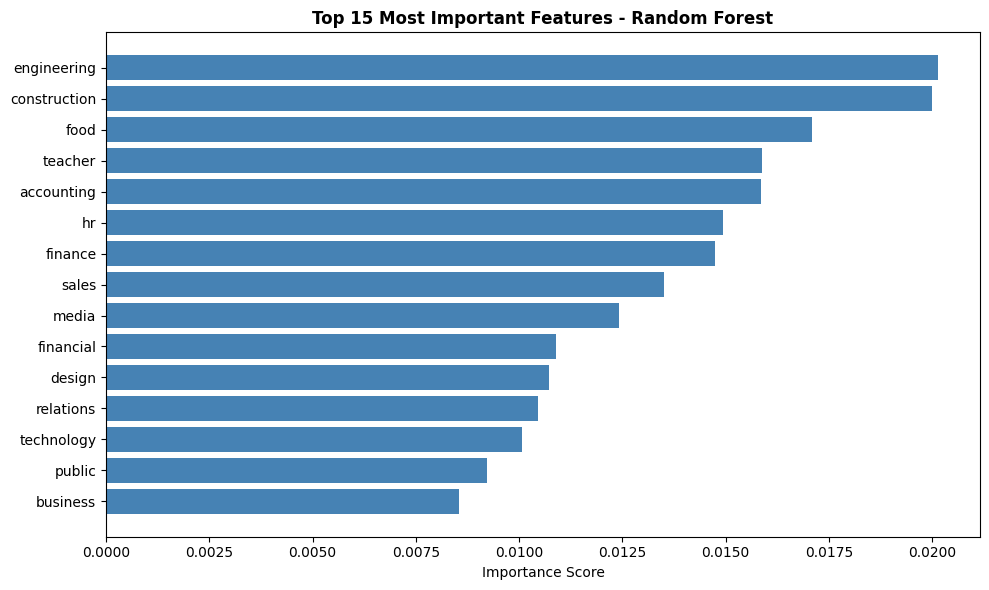


🔑 Top 5 Most Important Features:
   1. accounting: 0.0158
   2. teacher: 0.0159
   3. food: 0.0171
   4. construction: 0.0200
   5. engineering: 0.0201


In [16]:
# Get feature importance from Random Forest
feature_names = vectorizer.get_feature_names_out().tolist() + ['num_skills', 'resume_length', 'word_count']
importances = rf_model.feature_importances_

# Get top 15 most important features
top_indices = np.argsort(importances)[-15:]
top_features = [feature_names[i] for i in top_indices]
top_importances = importances[top_indices]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(15), top_importances, color='steelblue')
plt.yticks(range(15), top_features)
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Features - Random Forest', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔑 Top 5 Most Important Features:")
for i, (feature, importance) in enumerate(zip(top_features[-5:], top_importances[-5:]), 1):
    print(f"   {i}. {feature}: {importance:.4f}")

## Step 10: Save Models for Future Use

In [17]:
import joblib
import os

# Create directory for models if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save models
joblib.dump(rf_model, 'models/random_forest_model.pkl')
joblib.dump(lr_model, 'models/logistic_regression_model.pkl')
joblib.dump(vectorizer, 'models/tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')

print("💾 Models saved successfully!")
print("   ✅ models/random_forest_model.pkl")
print("   ✅ models/logistic_regression_model.pkl")
print("   ✅ models/tfidf_vectorizer.pkl")
print("   ✅ models/label_encoder.pkl")

💾 Models saved successfully!
   ✅ models/random_forest_model.pkl
   ✅ models/logistic_regression_model.pkl
   ✅ models/tfidf_vectorizer.pkl
   ✅ models/label_encoder.pkl


## Summary & Conclusion

In [18]:
print("="*70)
print("🎉 DELIVERABLE 3 COMPLETE!")
print("="*70)

print("\n📊 SUMMARY:")
print("-" * 70)
print(f"Dataset Size: {len(df)} resumes")
print(f"Number of Job Categories: {len(label_encoder.classes_)}")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")
print(f"Total Features: {X.shape[1]} (300 TF-IDF + 3 structured)")
print("-" * 70)

print("\n🤖 MODELS TRAINED:")
print("-" * 70)
print("1. Random Forest Classifier")
print(f"   - Accuracy: {rf_accuracy:.4f}")
print(f"   - F1-Score: {rf_f1:.4f}")
print()
print("2. Logistic Regression")
print(f"   - Accuracy: {lr_accuracy:.4f}")
print(f"   - F1-Score: {lr_f1:.4f}")
print("-" * 70)

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")

print("\n✅ All components successfully implemented:")
print("   ✓ Data preprocessing pipeline")
print("   ✓ Feature engineering (TF-IDF + structured features)")
print("   ✓ Two baseline ML models trained")
print("   ✓ Performance metrics calculated")
print("   ✓ Visualizations created")
print("   ✓ Models saved for future use")

print("\n📈 Next Steps (Deliverable 4):")
print("   → Integrate BERT for semantic matching")
print("   → Implement Reinforcement Learning agent")
print("   → Add SHAP/LIME explainability")
print("="*70)

🎉 DELIVERABLE 3 COMPLETE!

📊 SUMMARY:
----------------------------------------------------------------------
Dataset Size: 2484 resumes
Number of Job Categories: 24
Training Samples: 1987
Testing Samples: 497
Total Features: 303 (300 TF-IDF + 3 structured)
----------------------------------------------------------------------

🤖 MODELS TRAINED:
----------------------------------------------------------------------
1. Random Forest Classifier
   - Accuracy: 0.5714
   - F1-Score: 0.5351

2. Logistic Regression
   - Accuracy: 0.3038
   - F1-Score: 0.2931
----------------------------------------------------------------------

🏆 Best Model: Random Forest
   F1-Score: 0.5351

✅ All components successfully implemented:
   ✓ Data preprocessing pipeline
   ✓ Feature engineering (TF-IDF + structured features)
   ✓ Two baseline ML models trained
   ✓ Performance metrics calculated
   ✓ Visualizations created
   ✓ Models saved for future use

📈 Next Steps (Deliverable 4):
   → Integrate BERT for s